## Predicting Bike Sharing Demand using Machine Learning

There are 2 main sections covered in this notebook - __Part 1__ and __Part 2__.
- __Part 1__ offers a step-by-step walkthrough of the implemented methodology.


- __Part 2__ explores scalability considerations and options in detail.

## Part 1

In [32]:
import time
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import warnings
from scipy.stats.mstats import winsorize

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder 
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from sklearn.linear_model import Ridge, Lasso
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
import xgboost as xgb
# from catboost import CatBoostRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, KFold
from sklearn.model_selection import learning_curve, cross_validate
from sklearn.decomposition import PCA

In [2]:
day_df = pd.read_csv("bike_sharing_dataset/day.csv", parse_dates=['dteday'])
hour_df = pd.read_csv("bike_sharing_dataset/hour.csv", parse_dates=['dteday'])

day_df['dteday'] = day_df['dteday'].dt.tz_localize(None)
hour_df['dteday'] = hour_df['dteday'].dt.tz_localize(None)

In [3]:
day_df

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
726,727,2012-12-27,1,1,12,0,4,1,2,0.254167,0.226642,0.652917,0.350133,247,1867,2114
727,728,2012-12-28,1,1,12,0,5,1,2,0.253333,0.255046,0.590000,0.155471,644,2451,3095
728,729,2012-12-29,1,1,12,0,6,0,2,0.253333,0.242400,0.752917,0.124383,159,1182,1341
729,730,2012-12-30,1,1,12,0,0,0,1,0.255833,0.231700,0.483333,0.350754,364,1432,1796


## Verify if both the datasets are one and the same

In [4]:
# Combine dteday and hr to create a unique datetime index
hour_df['datetime'] = hour_df['dteday'] + pd.to_timedelta(hour_df['hr'], unit='h')

# Set the new datetime column as index
hour_df.set_index('datetime', inplace=True)

# Resample to daily frequency and sum the 'cnt' column
daily_data = hour_df['cnt'].resample('D').sum()

# Convert to a DataFrame
daily_data = daily_data.reset_index()

daily_data['cnt'].equals(day_df['cnt'])

True

In [5]:
hour_df = hour_df.reset_index(drop=True).set_index('dteday')

In [6]:
hour_df

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
dteday,,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16
2011-01-01,2,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40
2011-01-01,3,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32
2011-01-01,4,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13
2011-01-01,5,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31,17375,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119
2012-12-31,17376,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89
2012-12-31,17377,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90


## Summary of the dataset

In [7]:
pd.DataFrame({
    'Feature': hour_df.columns.values,
    'Datatype': hour_df.dtypes.values,
    'Negative_Values': [1 if (hour_df[col].values<0).any() else 0 for col in hour_df.select_dtypes(include=np.number).columns],
    'Null_Values': hour_df.isna().sum(),
    'Unique_value_count': hour_df.nunique().values, # number of uniques values in a column
    'Unique_values': [hour_df[col].unique() for col in hour_df.columns],
    'Duplicate Rows': hour_df.duplicated().sum() # number of duplicate rows
}).reset_index(drop=True)

,Feature,Datatype,Negative_Values,Null_Values,Unique_value_count,Unique_values,Duplicate Rows
0,instant,int64,0,0,17379,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",0
1,season,int64,0,0,4,"[1, 2, 3, 4]",0
2,yr,int64,0,0,2,"[0, 1]",0
3,mnth,int64,0,0,12,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]",0
4,hr,int64,0,0,24,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0
5,holiday,int64,0,0,2,"[0, 1]",0
6,weekday,int64,0,0,7,"[6, 0, 1, 2, 3, 4, 5]",0
7,workingday,int64,0,0,2,"[0, 1]",0
8,weathersit,int64,0,0,4,"[1, 2, 3, 4]",0
9,temp,float64,0,0,50,"[0.24, 0.22, 0.2, 0.32, 0.38, 0.36, 0.42, 0.46...",0


#### Observations:

- There are no missing, negative, or duplicate values in the dataset.


- Some features have values that have been normalized.


- There are no negative values to perform extra preprocessing and cleaning


- Some categorical fields are represented as integers, such as 'holiday', 'season', 'weathersit'.


- There are no duplicate rows that causes redundancy.

In [8]:
hour_df.describe(include='all')

,instant,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,17379.0000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000,17379.000000
mean,8690.0000,2.501640,0.502561,6.537775,11.546752,0.028770,3.003683,0.682721,1.425283,0.496987,0.475775,0.627229,0.190098,35.676218,153.786869,189.463088
std,5017.0295,1.106918,0.500008,3.438776,6.914405,0.167165,2.005771,0.465431,0.639357,0.192556,0.171850,0.192930,0.122340,49.305030,151.357286,181.387599
min,1.0000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.020000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,4345.5000,2.000000,0.000000,4.000000,6.000000,0.000000,1.000000,0.000000,1.000000,0.340000,0.333300,0.480000,0.104500,4.000000,34.000000,40.000000
50%,8690.0000,3.000000,1.000000,7.000000,12.000000,0.000000,3.000000,1.000000,1.000000,0.500000,0.484800,0.630000,0.194000,17.000000,115.000000,142.000000
75%,13034.5000,3.000000,1.000000,10.000000,18.000000,0.000000,5.000000,1.000000,2.000000,0.660000,0.621200,0.780000,0.253700,48.000000,220.000000,281.000000
max,17379.0000,4.000000,1.000000,12.000000,23.000000,1.000000,6.000000,1.000000,4.000000,1.000000,1.000000,1.000000,0.850700,367.000000,886.000000,977.000000


## Exploratory Data Analysis

In [9]:
# Changing the index to 'instant' as it is unique for all the rows
hour_df = hour_df.reset_index().set_index('instant')

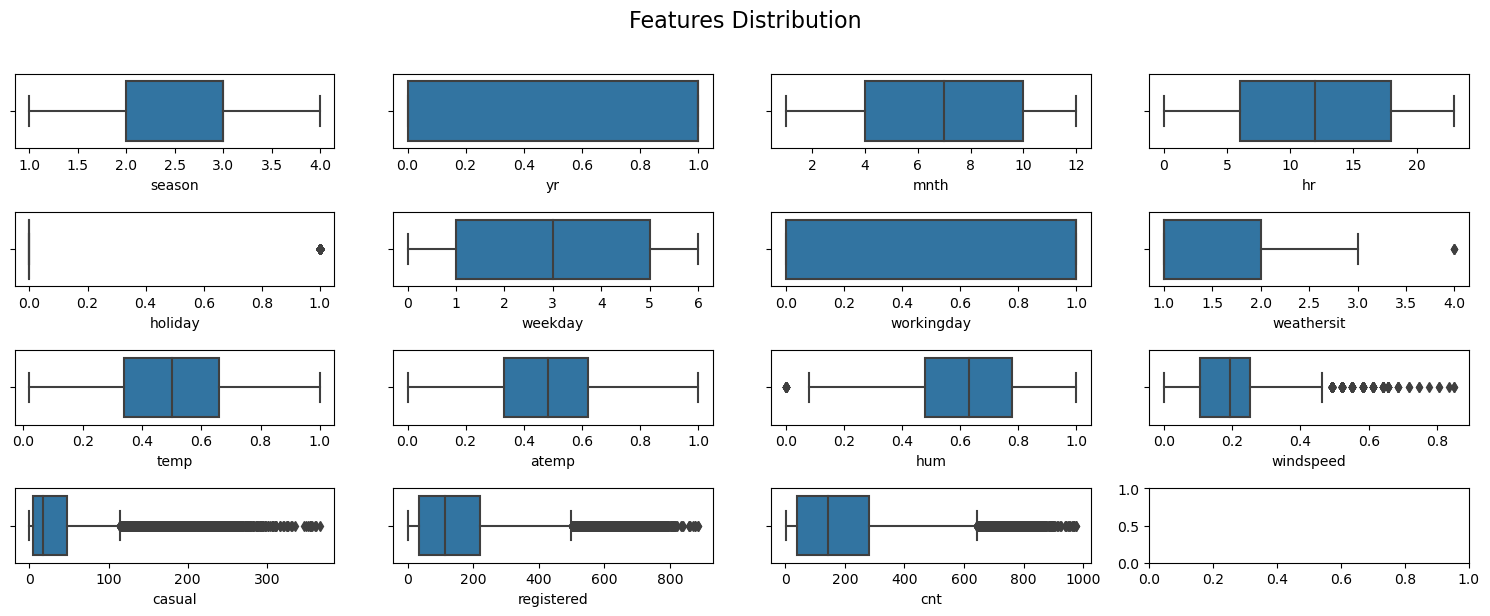

In [10]:
fig, axs = plt.subplots(nrows=4, ncols=4, figsize=(15, 6))
axs = axs.flatten()
warnings.filterwarnings("ignore")

for i in range(1, len(hour_df.columns)):
    sns.boxplot(x=hour_df.columns[i], data=hour_df, ax=axs[i-1], orient='v')

plt.suptitle('Features Distribution', y=1.02, fontsize=16)
plt.tight_layout()
plt.show()

#### Observations:

- Some of the features like `hr`, `season`, `temp` show normal distribution but most of them show right skewed distribution 


 - The outliers are evident in features like `windspeed`, `weathersit`, `cnt`, `casual` and `registered` 

### Adding additional time variables for better visualization and insights

In [11]:
hour_df['day'] = hour_df['dteday'].dt.day
hour_df['year'] = hour_df['yr'].apply(lambda x: 2011 if x==0 else 2012)

hour_df

,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,day,year
instant,,,,,,,,,,,,,,,,,,
1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,3,13,16,1,2011
2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,8,32,40,1,2011
3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,5,27,32,1,2011
4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,3,10,13,1,2011
5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,0,1,1,1,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17375,2012-12-31,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,11,108,119,31,2012
17376,2012-12-31,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,8,81,89,31,2012
17377,2012-12-31,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,7,83,90,31,2012


### Univariate analysis

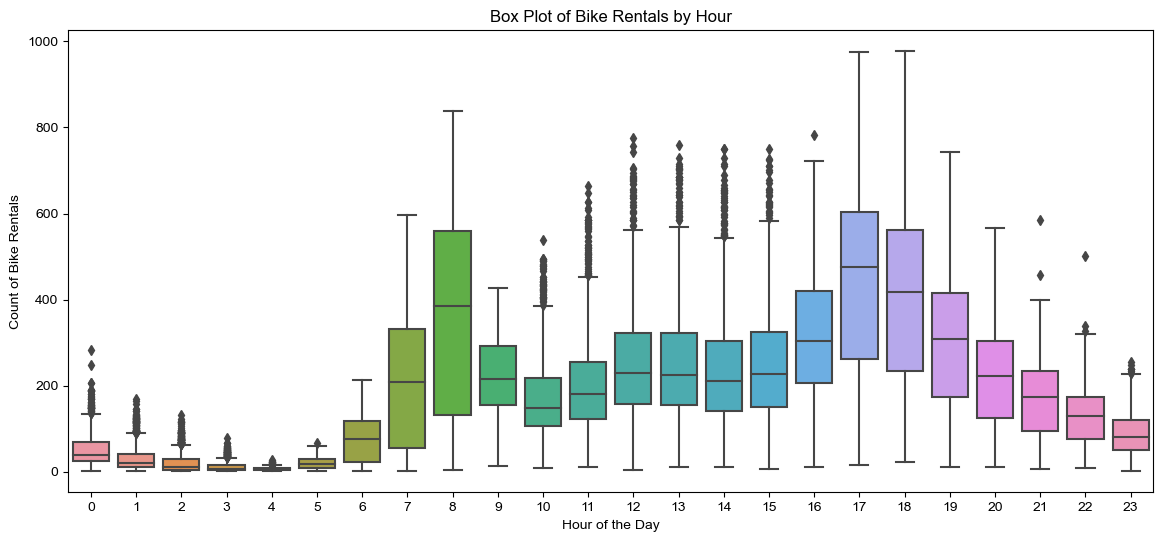

In [12]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='hr', y='cnt', data=hour_df)
sns.set_style('darkgrid')
plt.title('Box Plot of Bike Rentals by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Count of Bike Rentals')
plt.show()

#### Observations:

- The count of the bike sharing peaks at 5pm and 8PM and starts to pick pace from 6AM in the morning. This gives a very vague idea of people considering using bikes for commuting to school and work.


- Past midnight till 5AM, there are literally very low usage of bikes (the time window for reparing, or replacing the bikes)

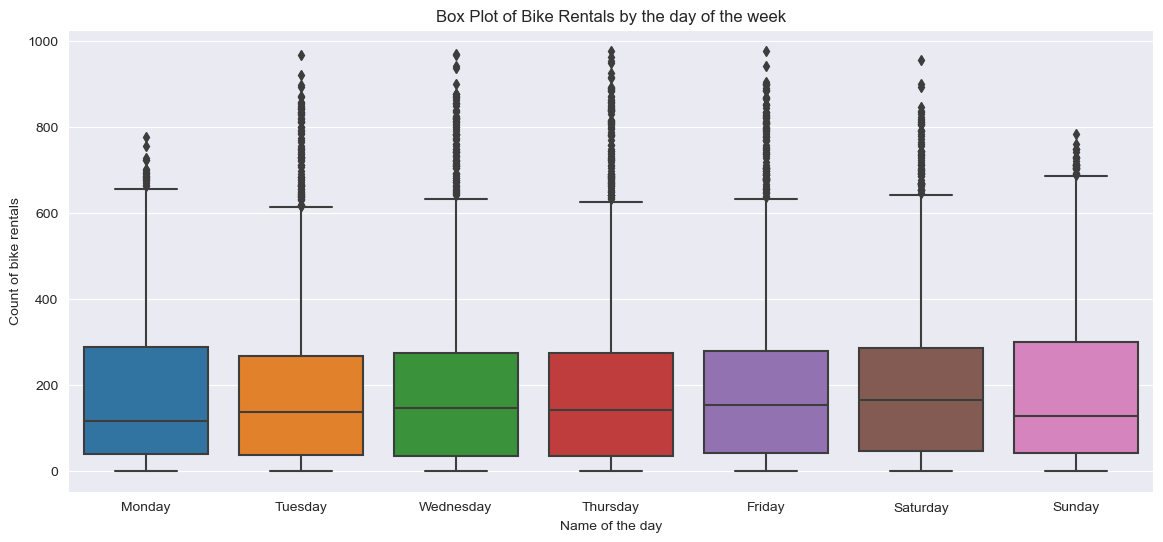

In [13]:
fig, axs = plt.subplots(1, 1, figsize=(14,6))

sns.boxplot(x='weekday', y='cnt', data=hour_df)
sns.set_style('darkgrid')

weekday = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

axs.set_xlabel('Name of the day')
axs.set_xticklabels(weekday)
axs.set_ylabel('Count of bike rentals')

plt.title('Box Plot of Bike Rentals by the day of the week')
plt.show()

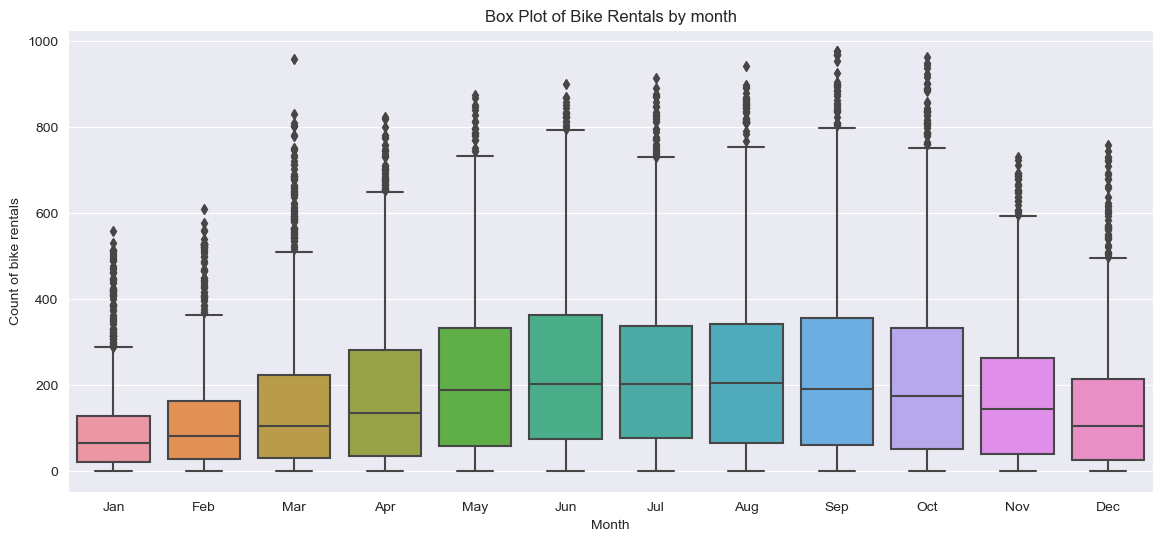

In [14]:
fig, axs = plt.subplots(1, 1, figsize=(14,6))

sns.boxplot(x='mnth', y='cnt', data=hour_df)
sns.set_style('darkgrid')

month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

axs.set_xlabel('Month')
axs.set_xticklabels(month_list)
axs.set_ylabel('Count of bike rentals')

plt.title('Box Plot of Bike Rentals by month')
plt.show()

#### Observations:

- __Seasonal Trends in Bike Sharing__: Bike-sharing activity starts to rise in March, reaching its highest levels in September. This trend highlights the increased usage of bikes during the summer and late summer seasons.


- __Winter Decline and Spring Increase__: There is a notable decline in bike-sharing during the winter months, particularly from December to February, due to colder weather. Conversely, bike usage begins to increase in the spring (March and April) and decreases again in the fall (October and November).

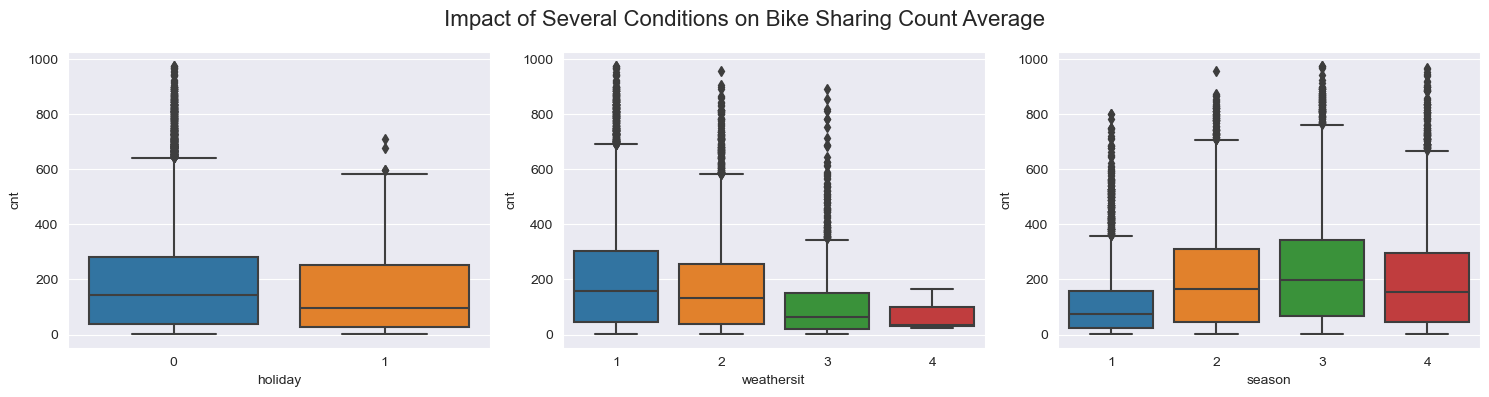

In [15]:
fig, axs = plt.subplots(1, 3, figsize=(15,4))
color = sns.color_palette("tab10")

sns.boxplot(data=hour_df, x='holiday', y='cnt', ax=axs[0], palette=color)
sns.boxplot(data=hour_df, x='weathersit', y='cnt', ax=axs[1], palette=color)
sns.boxplot(data=hour_df, x='season', y='cnt', ax=axs[2], palette=color)


plt.suptitle('Impact of Several Conditions on Bike Sharing Count Average', fontsize=16)
plt.tight_layout()
plt.show()

#### Observations:

- __Impact of Weather on Bike Rentals__: Ideal weather conditions (code 1) lead to the highest number of bicycle rentals, while poorer conditions, such as mist or cloudy weather (code 2), result in lower bike usage.


- __Extreme Weather's Negative Effect__: Severe weather conditions, like heavy rain, ice pellets, thunderstorms, and thick fog (codes 3 and 4), significantly reduce bike-sharing activity.


- __Weather's Role in Bike Usage__: Clear and pleasant weather encourages more people to use bikes, highlighting the need for weather analysis in bike-sharing operational planning.


- __Seasonal and Holiday Variations__: Bike-sharing numbers are lower on holidays compared to regular days, and summer sees the highest usage, followed by fall, spring, and winter with the least activity.

### Numerical features 
Numerical features like temp, atemp, humidity (hum), windspeed are converted to their actual values for better understanding of insights

In [16]:
temp_min, temp_max = -8, 39
atemp_min, atemp_max = -16, 50

original_atemp = hour_df['atemp']*(atemp_max-atemp_min)+atemp_min
original_temp = hour_df['temp']*(temp_max-temp_min)+temp_min
original_hum = hour_df['hum']*100
original_windspeed = hour_df['windspeed']*67

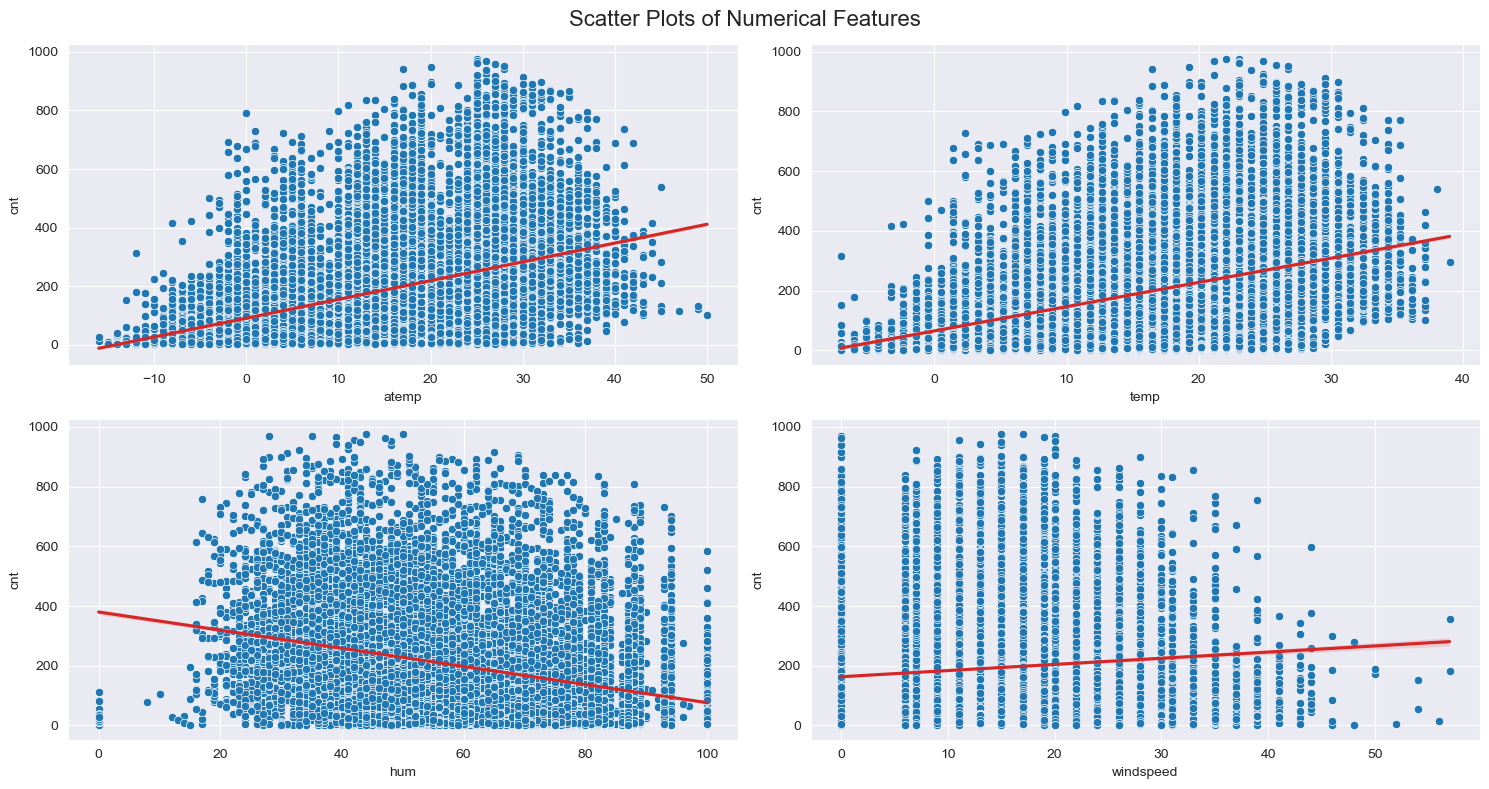

In [17]:
fig, axs = plt.subplots(2, 2, figsize=(15,8))
axs.flatten()

sns.scatterplot(data=hour_df, x=original_atemp, y='cnt', ax=axs[0,0])
sns.regplot(data=hour_df, x=original_atemp, y='cnt', ax=axs[0, 0], scatter=False, color=color[3])

sns.scatterplot(data=hour_df, x=original_temp, y='cnt', ax=axs[0,1])
sns.regplot(data=hour_df, x=original_temp, y='cnt', ax=axs[0, 1], scatter=False, color=color[3])

sns.scatterplot(data=hour_df, x=original_hum, y='cnt', ax=axs[1,0])
sns.regplot(data=hour_df, x=original_hum, y='cnt', ax=axs[1, 0], scatter=False, color=color[3])

sns.scatterplot(data=hour_df, x=original_windspeed, y='cnt', ax=axs[1,1])
sns.regplot(data=hour_df, x=original_windspeed, y='cnt', ax=axs[1, 1], scatter=False, color=color[3])

plt.suptitle('Scatter Plots of Numerical Features', fontsize=16)
plt.tight_layout()
plt.show()

#### Observations

- The relationship 'temp' or 'atemp' features to 'cnt' has a positive linear pattern.


- Value 0 in 'hum' feature looks like an outlier because it is far from dominant.


- There is a negative linear relationship between 'hum' and 'cnt', where when the humidity level increases, the number of bicycle uses tends to decrease.


- Values greater than 50 in the 'windspeed' feature look like outliers because they are far from dominant.

### Bivariate analysis

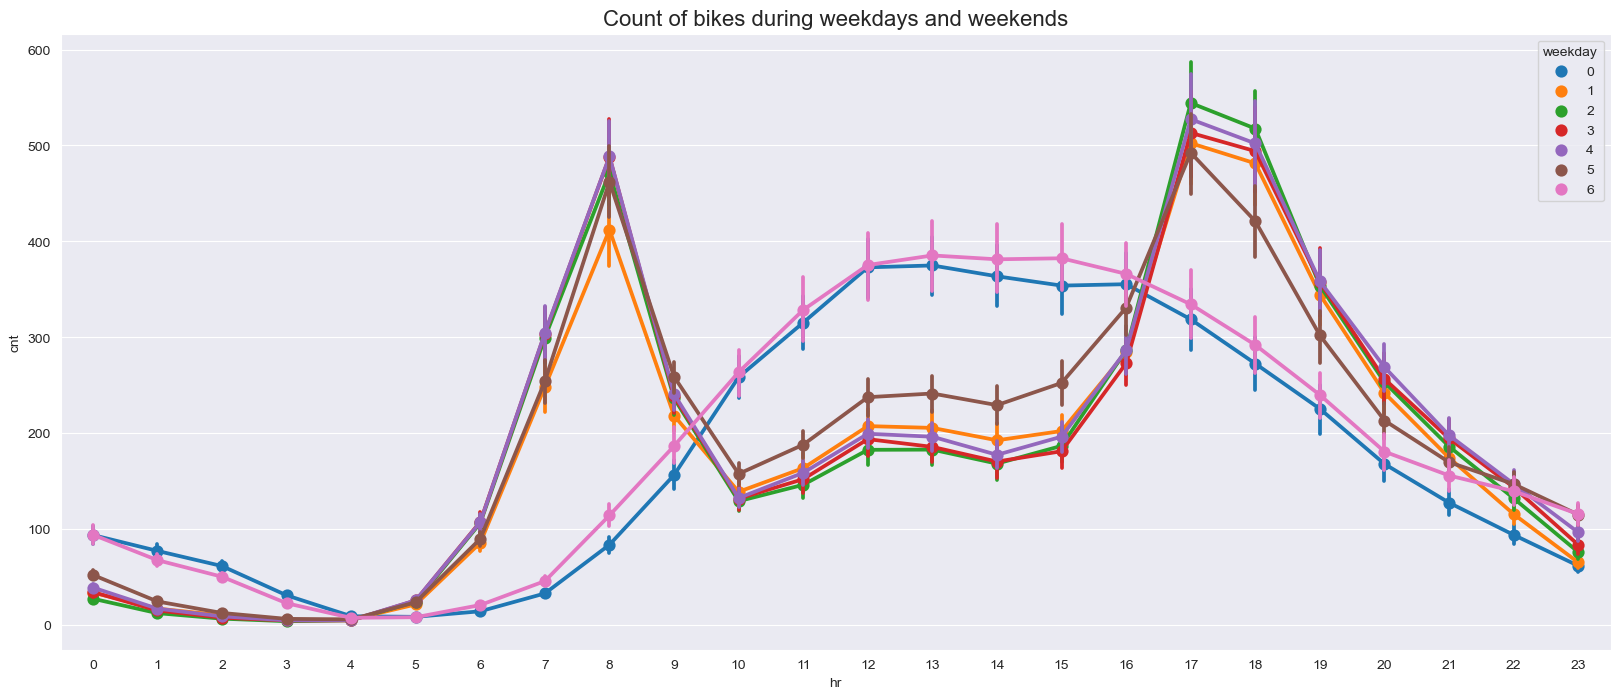

In [18]:
fig, ax = plt.subplots(figsize=(20,8))
sns.pointplot(data=hour_df, x='hr', y='cnt', hue='weekday', palette=color, ax=ax)
plt.title('Count of bikes during weekdays and weekends', fontsize=16)
plt.show()

#### Observations:

- __Weekday Commuting Patterns__: Bike sharing significantly increases between 6 - 8 am and 4 - 6 pm on weekdays (Monday - Friday), suggesting that people use bicycles for commuting to and from work or school.


- __Weekend Usage Trends__: On weekends (Saturday and Sunday), bike-sharing activity rises throughout the day, peaking around 1 pm.

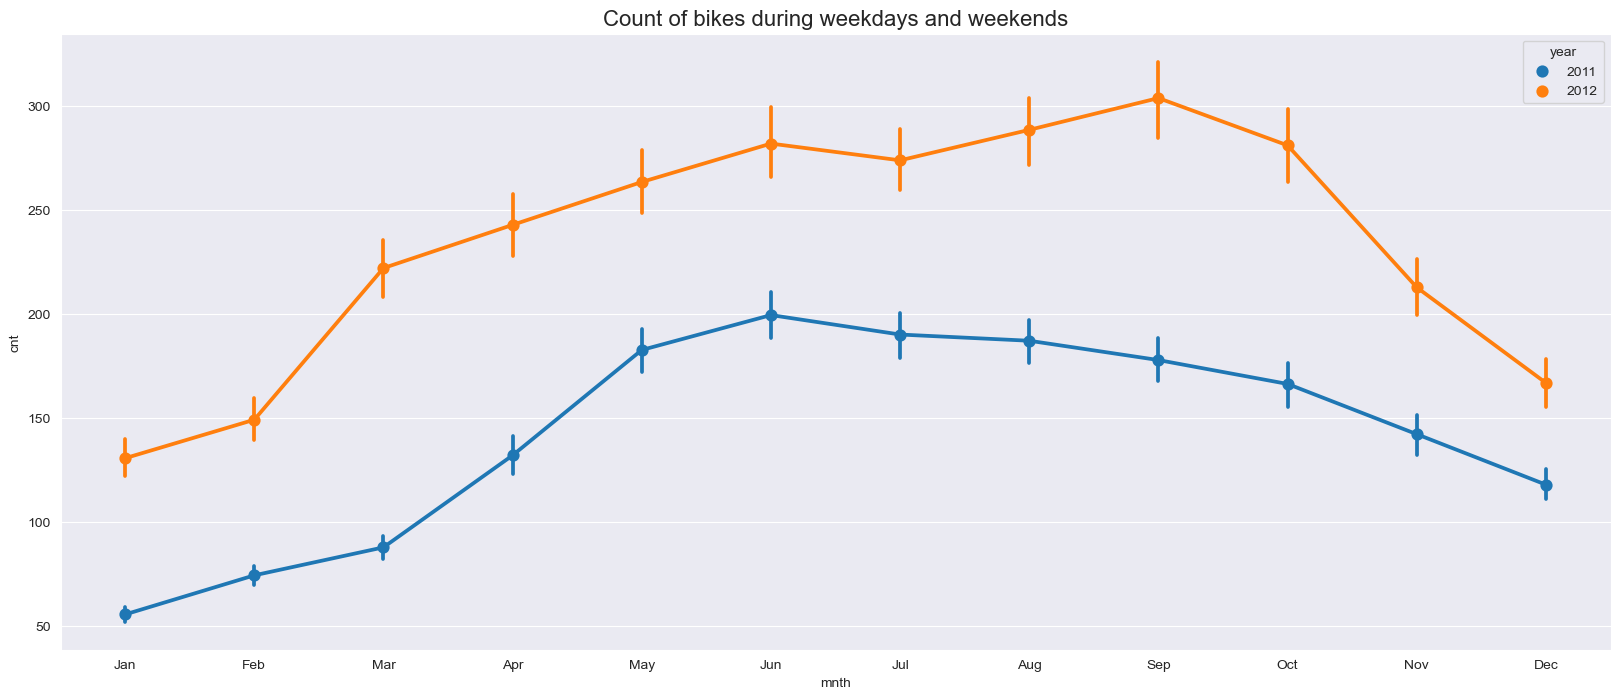

In [20]:
fig, ax = plt.subplots(figsize=(20,8))
sns.pointplot(data=hour_df, x='mnth', y='cnt', hue='year', palette=color, ax=ax)

month_list = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
ax.set_xticklabels(month_list)
plt.title('Count of bikes each year', fontsize=16)
plt.show()

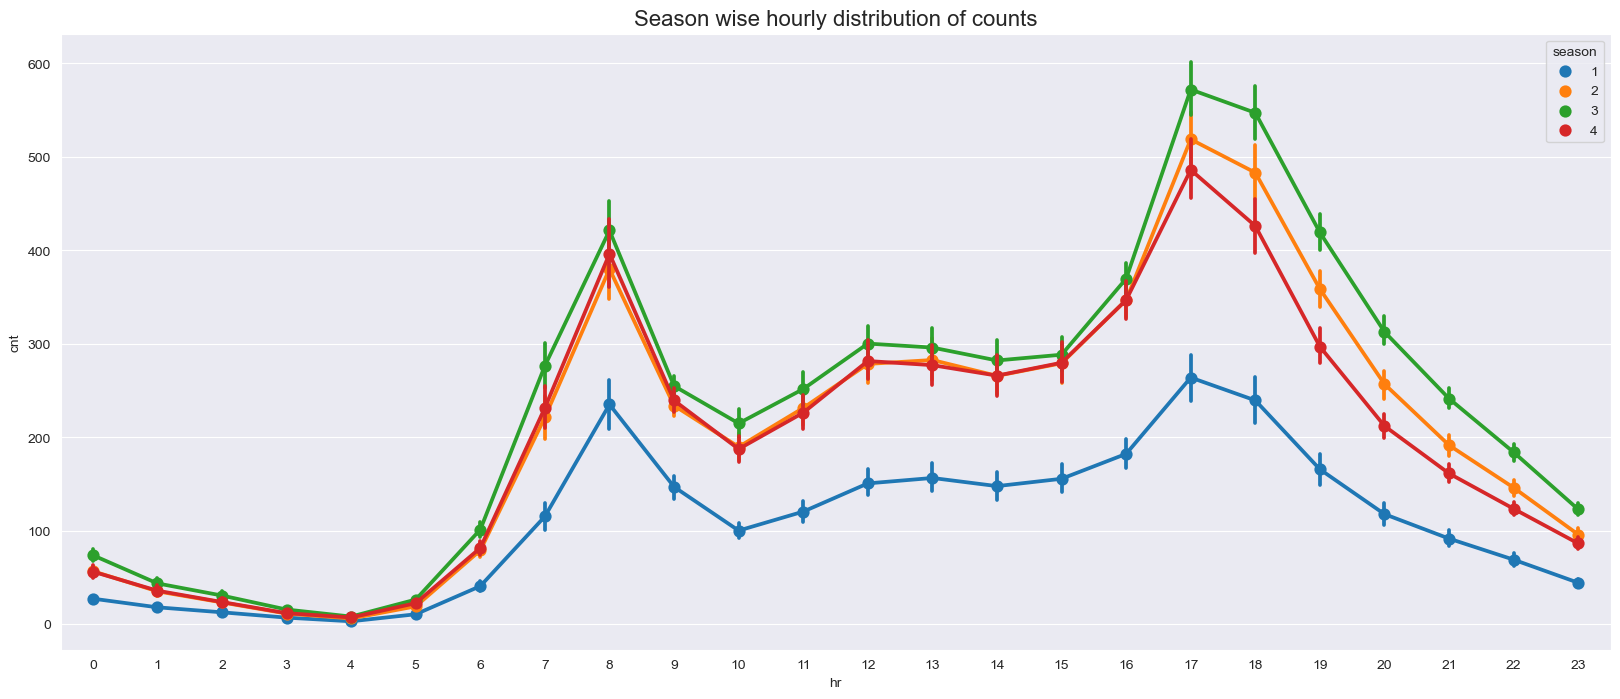

In [19]:
fig, ax = plt.subplots(figsize=(20,8))
sns.pointplot(data=hour_df, x='hr', y='cnt', hue='season', palette=color, ax=ax)
plt.title('Season wise hourly distribution of counts', fontsize=16)
plt.show()

#### Impact of holidays

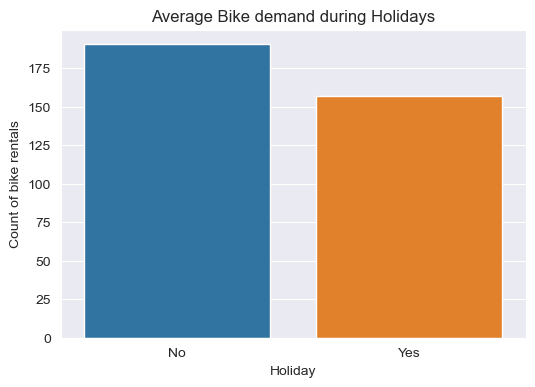

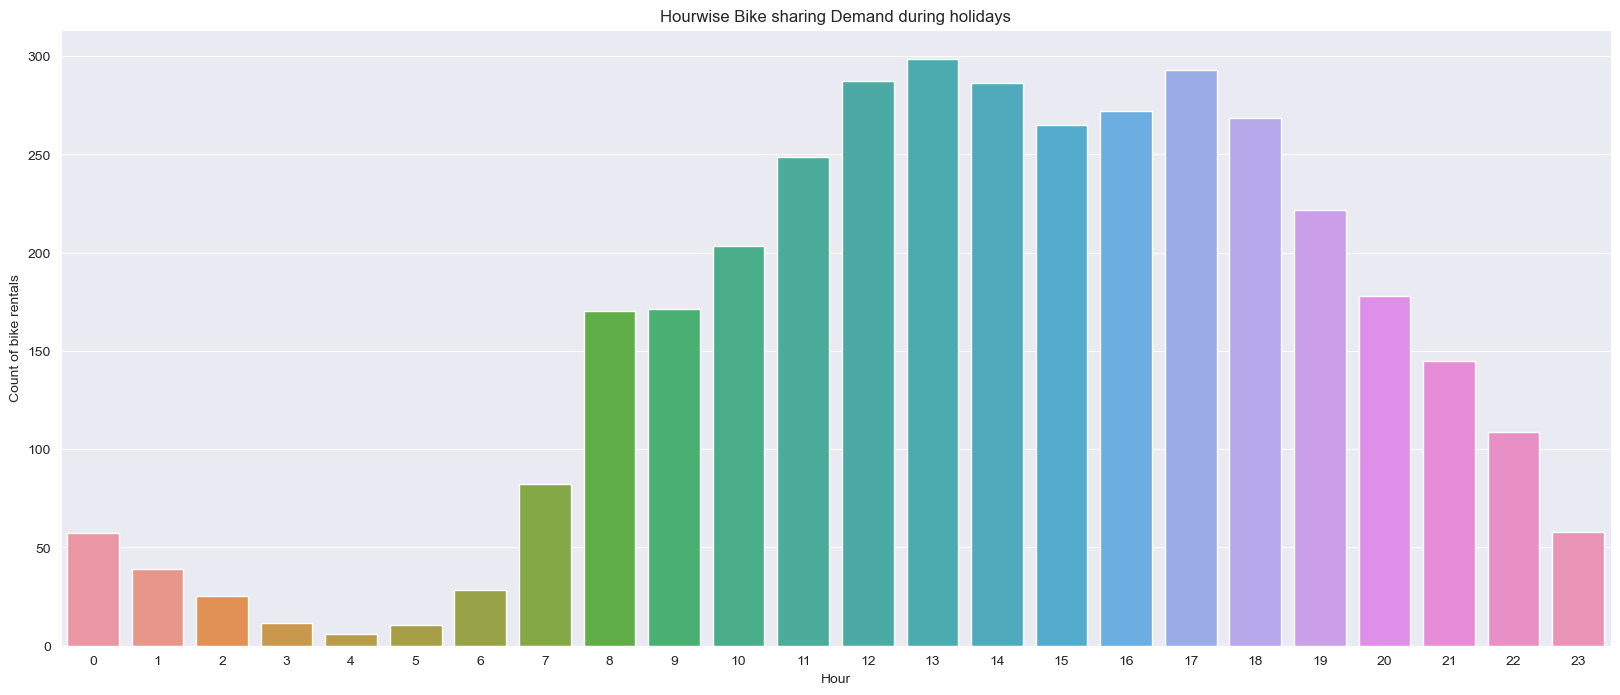

In [22]:
y = hour_df.groupby('holiday')['cnt'].mean().reset_index()
c = hour_df[hour_df.holiday==1].groupby('hr')['cnt'].mean().reset_index()

fig, ax = plt.subplots(figsize=(6, 4))

sns.barplot(x ='holiday', y ='cnt', data = y).set_title('Average Bike demand during Holidays')
is_holiday = ['No', 'Yes']

ax.set_xlabel('Holiday')
ax.set_xticklabels(is_holiday)
ax.set_ylabel('Count of bike rentals')
plt.show()

fig, ax = plt.subplots(figsize=(20,8))
sns.barplot(x ='hr', y ='cnt', data = c).set_title('Hourwise Bike sharing Demand during holidays')

ax.set_xlabel('Hour')
ax.set_ylabel('Count of bike rentals')
plt.show()

#### Observation:

- As started above, during holidays, the highest number of bike rentals happen between 12pm to 6pm. This is something to think about as it is very consistent throughout the year. Some kind of exclusive offers can be given in the morning from 7AM to promote and attract more customers during holidays.

### Spearman Correlation of Data

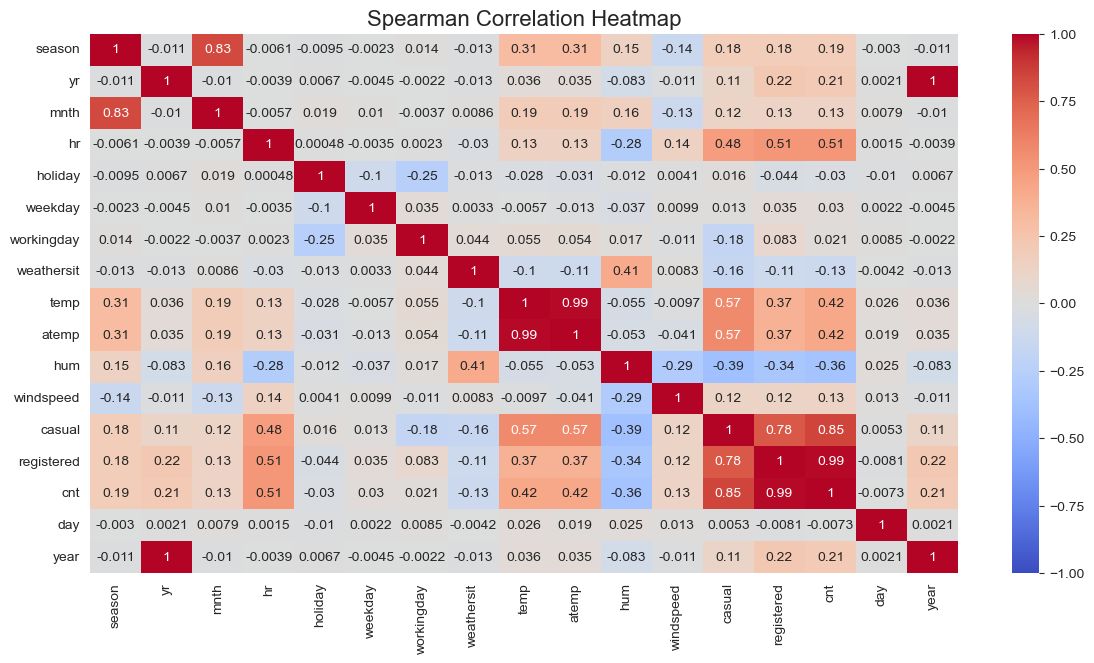

In [20]:
plt.figure(figsize=(14,7))
sns.heatmap(hour_df.corr('spearman'), annot=True, vmin=-1, vmax=1, cmap='coolwarm')

plt.title('Spearman Correlation Heatmap', fontsize=16)
plt.show()

#### Observations:

- __Correlation with 'cnt'__: The 'cnt' feature is highly correlated with 'casual' and 'registered' since it is a sum of these two. Dropping 'casual' and 'registered' prevents redundancy as they are part of the target variable.


- __Multicollinearity Concerns__: 'Month' and 'season' show a high correlation (0.83), but they pass the multicollinearity threshold of 0.9. However, 'temp' and 'atemp' have a very strong positive correlation (0.9), indicating multicollinearity; hence, one will be dropped.


- __Temperature Influence__: Both 'temp' and 'atemp' have a moderate positive correlation with 'cnt', indicating that higher temperatures tend to increase bike rentals.


- __Humidity and Weather Impact__: 'Humidity' shows a moderate negative correlation with 'cnt', suggesting people prefer biking in lower humidity. Additionally, 'weathersit' has a low negative correlation with 'cnt', indicating worse weather conditions reduce bike-sharing activity.


- __Insignificant Features__: 'Year', 'season', 'month', 'holiday', 'weekday', and 'day' have low correlations with 'cnt', implying they do not significantly influence bike-sharing counts. 'Windspeed' also shows a low positive correlation, indicating minimal impact on rentals.

## Outlier Detection

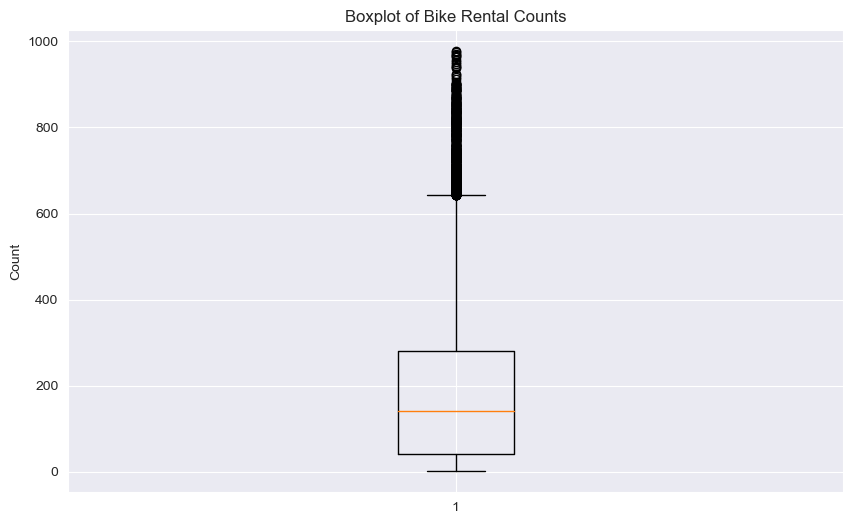

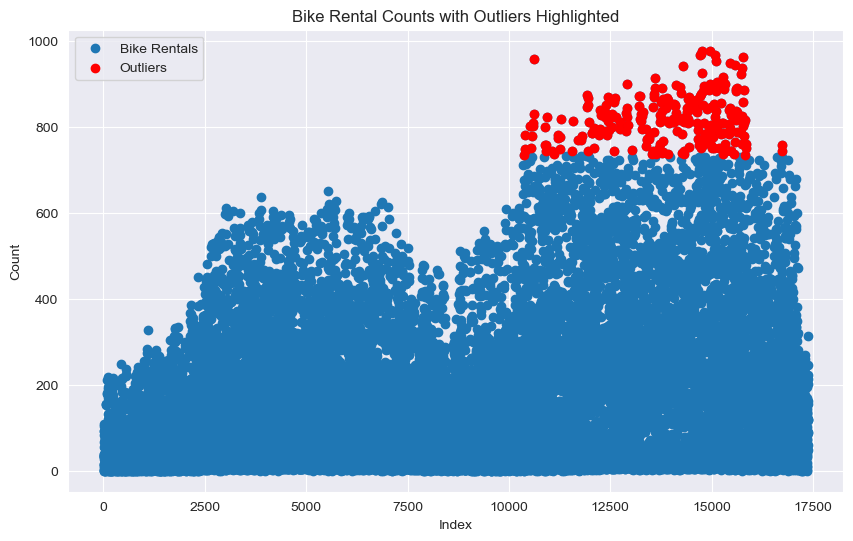

In [21]:
# Outlier detection using a boxplot
plt.figure(figsize=(10, 6))
plt.boxplot(hour_df['cnt'])
plt.title('Boxplot of Bike Rental Counts')
plt.ylabel('Count')
plt.show()

# Calculate z-scores for the 'cnt' column
mean_cnt = hour_df['cnt'].mean()
std_cnt = hour_df['cnt'].std()
z_scores = (hour_df['cnt'] - mean_cnt) / std_cnt

# Set a threshold for outlier detection (e.g., z-score > 3)
outlier_threshold = 3
outliers = hour_df[z_scores > outlier_threshold]

# Visualize the data and highlight outliers
plt.figure(figsize=(10, 6))
plt.scatter(hour_df.index, hour_df['cnt'], label='Bike Rentals')
plt.scatter(outliers.index, outliers['cnt'], color='red', label='Outliers')
plt.title('Bike Rental Counts with Outliers Highlighted')
plt.xlabel('Index')
plt.ylabel('Count')
plt.legend()
plt.show()

### Checking the outlier distribution across various features

In [22]:
def identify_outliers(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data[column] < lower_bound) | (data[column] > upper_bound)]
    return outliers, lower_bound, upper_bound

def summarize_outliers(data):
    summary = []
    for column in data.columns:
        if column in ['dteday', 'holiday']:
            continue
        outliers, lower, upper = identify_outliers(data, column)
        num_outliers = len(outliers)
        percentage = round((num_outliers / len(data)) * 100, 2)
        summary.append({
            "Column": column,
            "Total Outliers": num_outliers,
            "Percentage (%)": percentage,
            "Lower Bound": lower,
            "Upper Bound": upper
        })
    return pd.DataFrame(summary)

In [23]:
summarize_outliers(hour_df)

,Column,Total Outliers,Percentage (%),Lower Bound,Upper Bound
0,season,0,0.00,0.50000,4.50000
1,yr,0,0.00,-1.50000,2.50000
2,mnth,0,0.00,-5.00000,19.00000
3,hr,0,0.00,-12.00000,36.00000
4,weekday,0,0.00,-5.00000,11.00000
5,workingday,0,0.00,-1.50000,2.50000
6,weathersit,3,0.02,-0.50000,3.50000
7,temp,0,0.00,-0.14000,1.14000
8,atemp,0,0.00,-0.09855,1.05305
9,hum,22,0.13,0.03000,1.23000


### Quick Insights:

- After analyzing the total bike rental count using Z-Score and IQR methods, I identified approximately 400 outliers. Given our objective to predict hourly bike-sharing demand accurately and ensure a stable supply, I chose to retain these outliers. This decision allows me to capture unusual demand patterns that may occur. However, I will apply the winsorizing method to the 'weathersit', 'humidity', and 'windspeed' features, setting upper and lower bounds at 1% to handle extreme values. 


- Utilizing Spearman Correlation analysis, I identified multicollinearity issues and consequently remove the 'atemp' feature. Additionally, to address redundancy, I will exclude the 'casual' and 'registered' features, focusing on the overall prediction of bike-sharing demand.

__Winsorization__ is a data preprocessing technique that mitigates the impact of outliers by replacing outlier values with predefined cutoffs. This process stabilizes data distribution and reduces the influence of extreme data points.

In [24]:
# winsorize the features
transformed_df = hour_df.copy(deep=False)
# transformed_df['weathersit'] = winsorize(transformed_df['weathersit'], limits=(0.01, 0.1))
transformed_df['hum'] = winsorize(transformed_df['hum'], limits=(0.01, 0.1))
transformed_df['windspeed'] = winsorize(transformed_df['windspeed'], limits=(0.01, 0.1))

# Cyclical encoding for hour
transformed_df['hour_sin'] = np.sin(2 * np.pi * transformed_df['hr'] / 24)
transformed_df['hour_cos'] = np.cos(2 * np.pi * transformed_df['hr'] / 24)

# Dropping certain features that cause multicollinearity and redundancy that negatively affect model performance
transformed_df=transformed_df.drop(labels=['dteday','atemp','casual','registered', 'year'],axis=1)

## Seprating Independent and dependent features
X = transformed_df.drop(labels=['cnt'],axis=1)
Y = transformed_df[['cnt']]

In [25]:
transformed_df

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,hum,windspeed,cnt,day,hour_sin,hour_cos
instant,,,,,,,,,,,,,,,
1,1,0,1,0,0,6,0,1,0.24,0.81,0.0000,16,1,0.000000,1.000000
2,1,0,1,1,0,6,0,1,0.22,0.80,0.0000,40,1,0.258819,0.965926
3,1,0,1,2,0,6,0,1,0.22,0.80,0.0000,32,1,0.500000,0.866025
4,1,0,1,3,0,6,0,1,0.24,0.75,0.0000,13,1,0.707107,0.707107
5,1,0,1,4,0,6,0,1,0.24,0.75,0.0000,1,1,0.866025,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17375,1,1,12,19,0,1,1,2,0.26,0.60,0.1642,119,31,-0.965926,0.258819
17376,1,1,12,20,0,1,1,2,0.26,0.60,0.1642,89,31,-0.866025,0.500000
17377,1,1,12,21,0,1,1,1,0.26,0.60,0.1642,90,31,-0.707107,0.707107


In [26]:
# Splitting the dataset into training and test set
X_train,X_test,y_train,y_test=train_test_split(X,Y,test_size=0.30,random_state=30)

In [27]:
# Define numerical and categorical columns
numerical_cols = ['temp', 'hum', 'windspeed', 'hour_sin', 'hour_cos']
binary_cols = ['holiday', 'workingday', 'yr', 'day']
one_hot_cols = ['season', 'mnth', 'weekday', 'weathersit']

# Numerical Pipeline
num_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ]
)

# One-Hot Encoding Pipeline
one_hot_pipeline = Pipeline(
    steps=[
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('onehot', OneHotEncoder(handle_unknown='ignore'))
    ]
)

# Combine the pipelines into the ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_pipeline, numerical_cols),
        ('onehot', one_hot_pipeline, one_hot_cols),
        ('binary', 'passthrough', binary_cols)
    ]
)

# Initialize the scaler for the target variable
target_scaler = StandardScaler()

# Fit the scaler on the training target and transform
y_train_scaled = target_scaler.fit_transform(y_train.values.reshape(-1, 1))

# Transform the testing target
y_test_scaled = target_scaler.transform(y_test.values.reshape(-1, 1))

# # Fit the preprocessor on the data
preprocessor.fit(X_train)
X_train_processed = preprocessor.transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# convert the preprocessed data back to a DataFrame
# Get the feature names after preprocessing
one_hot_feature_names = preprocessor.named_transformers_['onehot']['onehot'].get_feature_names_out(one_hot_cols)
binary_feature_names = binary_cols  # Directly passed through features
num_feature_names = numerical_cols  # Scaled numerical features

# Combine all feature names
all_feature_names = np.concatenate([num_feature_names, one_hot_feature_names, binary_feature_names])
# Debugging: Print the number of feature names
print("Number of feature names:", len(all_feature_names))

# Create DataFrame with preprocessed data
X_train_processed_df = pd.DataFrame(X_train_processed, columns=all_feature_names)
X_test_processed_df = pd.DataFrame(X_test_processed, columns=all_feature_names)


# Print the shape of the preprocessed data to verify
print(X_train_processed_df.shape)
print(X_test_processed_df.shape)


Number of feature names: 36
(12165, 36)
(5214, 36)


### Summary: The variables needed for training are below

- __X_train_processed_df__ 
- __X_test_processed_df__
- __y_train__
- __y_test__
- __y_train_scaled__
- __y_test_scaled__

In [30]:
X_train_processed_df

,temp,hum,windspeed,hour_sin,hour_cos,season_1,season_2,season_3,season_4,mnth_1,...,weekday_5,weekday_6,weathersit_1,weathersit_2,weathersit_3,weathersit_4,holiday,workingday,yr,day
0,-0.192936,1.406105,-0.733352,1.430883,-0.002447,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,20.0
1,-0.296368,1.406105,-1.707918,1.430883,-0.002447,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,10.0
2,-0.503231,1.406105,0.380171,-0.692142,1.221467,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
3,-0.813525,-0.717413,0.380171,-1.351590,-0.368224,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,11.0
4,1.151674,0.643816,-0.455438,0.723208,-1.226361,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12160,-2.261567,-0.717413,-1.707918,-0.692142,1.221467,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,22.0
12161,0.634516,0.861613,-0.872309,0.723208,-1.226361,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,23.0
12162,1.048242,0.153774,-1.707918,-1.399817,-0.002447,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,3.0
12163,1.048242,0.916062,-1.707918,1.016337,0.996874,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,12.0


In [74]:
X_test_processed_df

,num__temp,num__hum,num__windspeed,num__hour_sin,num__hour_cos,onehot__season_1,onehot__season_2,onehot__season_3,onehot__season_4,onehot__mnth_1,...,onehot__weekday_5,onehot__weekday_6,onehot__weathersit_1,onehot__weathersit_2,onehot__weathersit_3,onehot__weathersit_4,binary__holiday,binary__workingday,binary__yr,binary__day
0,1.048242,0.643816,-0.176590,1.016337,-1.001769,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,13.0
1,-0.710094,-1.207456,1.075890,0.723208,1.221467,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,14.0
2,-0.399799,-0.662964,0.658086,1.241262,-0.709074,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0
3,1.461969,-0.880761,1.075890,1.016337,-1.001769,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0
4,-0.503231,1.079410,-0.872309,1.430883,-0.002447,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,23.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5209,1.048242,1.188308,-0.176590,0.381853,-1.367546,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,6.0
5210,0.013927,1.406105,-0.872309,1.241262,0.704180,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,24.0
5211,0.531085,-0.336269,1.632652,-0.692142,-1.226361,0.0,0.0,0.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,6.0
5212,1.461969,-0.880761,1.075890,0.381853,-1.367546,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,9.0


## Model Training

In [55]:
# Helper function to evaluate model performance with cross-validation
def cross_val_evaluate(model, X, y, cv=5):
    start_time = time.time()
    
    scoring = {
        'MAE': 'neg_mean_absolute_error',
        'MSE': 'neg_mean_squared_error',
        'R2': 'r2',
        'MAPE': 'neg_mean_absolute_percentage_error'
    }
    
    scores = cross_validate(model, X, y, cv=cv, scoring=scoring, return_train_score=True)
    training_time = time.time() - start_time
    
    metrics = {
        'MAE': -scores['test_MAE'].mean(),
        'MSE': -scores['test_MSE'].mean(),
        'RMSE': np.sqrt(-scores['test_MSE'].mean()),
        'R2': scores['test_R2'].mean(),
        'MAPE': -scores['test_MAPE'].mean(),
        'Training Time': training_time
    }
    
    return metrics

# Models to evaluate
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(),
    'SVR': SVR(),
    'RandomForest': RandomForestRegressor(),
    'DecisionTree': DecisionTreeRegressor(),
    'LightGBM': lgb.LGBMRegressor(),
    'XGBoost': xgb.XGBRegressor(),
#     'CatBoost': CatBoostRegressor(silent=True)
}

# Evaluate each model with appropriate target scaling
results = {}
for name, model in models.items():
    print(f"Training {name}...")
    metrics = cross_val_evaluate(model, X_train_processed_df, y_train.values.ravel())
    results[name] = metrics
    
# Display the results
results_df = pd.DataFrame(results).T
print(results_df)

Training Ridge...
Training Lasso...
Training SVR...
Training RandomForest...
Training DecisionTree...
Training LightGBM...
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 259
[LightGBM] [Info] Number of data points in the train set: 9732, number of used features: 35
[LightGBM] [Info] Start training from score 190.119811
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 259
[LightGBM] [Info] Number of data points in the train set: 9732, number of used features: 35
[LightGBM] [Info] Start training from score 190.493013
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the ove

### Description of the models and Reasoning:

- __Ridge Regression__: Ridge Regression is a linear regression variant that includes a regularization term (L2 norm) to prevent overfitting. It is particularly useful when multicollinearity is present in the dataset.


- __Lasso Regression__: Lasso Regression is similar to Ridge Regression but uses the L1 norm for regularization. It not only helps prevent overfitting but also performs feature selection by driving some coefficients to exactly zero.


- __Support Vector Regression (svr)__: Support Vector Regression uses support vectors to perform linear regression. It aims to find a hyperplane that best represents the data while minimizing deviations from the actual values.


- __Random Forest Regressor__: Random Forest is an ensemble learning method that constructs a multitude of decision trees during training and outputs the mean prediction of the individual trees for regression tasks. It helps reduce overfitting and improves accuracy.


- __Decision Tree Regressor__: Decision tree is a tree-shaped model that represents a set of decisions based on features. It recursively splits the dataset into subsets based on the most significant attribute, resulting in a tree structure.


- __XGBoost Regressor__: XGBoost is an optimized gradient boosting algorithm that is widely used for regression tasks. It sequentially builds a series of decision trees, correcting errors of the previous ones, and combines their predictions. This suffers the problems of overfitting as this tries to fix the previous errors that tends to capture some unwanted patterns.


__Disclaimer__: The definitions are flicked from Google and other sources on the internet.

#### Results discussion:

I dont want to go over the definition of the metrics and why they have been considered assuming it is already known.

- __Ridge and Lasso regressors__ performed significantly poor that is reflected in all the metrics considered.


- The __Random Forest Regressor__ excelled in MAPE and MAE, closely matching XGBoost and surpassing LightGBM. The Decision Tree Regressor performed similarly to Random Forest but trained much faster.


- __Extreme Gradient Boosting__ is ahead of all the models showing solid performance with realtive low MAE (25.94), MAPE (48%), and high R2 (0.95) values and faster training times (1.34 sec). R2 value close to 1 indicates that the model effectively explains data variations.


- Shockingly, __Support Vector Regression__ shows the lowest performance with highest error values of MAE and MAPE, as well as a lowest R2. This suggests that the model may not be suitable for this experiment or requires further parameter adjustments.



__Therefore__, based on the above results and analysis, I decided to go ahead with __XGBoost__ and __Random Forest__ Regressors for further fine-tuning and improving the model performance in terms of most of the metrics considered.

In [57]:
# Select top 2 models based on different metrics
top_models = ['RandomForest', 'XGBoost']

# Hyperparameter tuning for top 2 models
param_grids = {
    'RandomForest': {
        'n_estimators': [50, 100],
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10]
    },
    'XGBoost': {
        'n_estimators': [100, 200, 300],       # Number of boosting rounds
        'max_depth': [3, 6, 9],                # Maximum depth of a tree
        'learning_rate': [0.01, 0.1, 0.2],     # Learning rate
    }
}

best_models = {}

for model_name in top_models:
    print(f"Tuning hyperparameters for {model_name}...")
    model = models[model_name]
    param_grid = param_grids[model_name]
    
    grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='r2', n_jobs=-1, verbose=2)
    grid_search.fit(X_train_processed_df, y_train.values.ravel())
    
    best_models[model_name] = grid_search.best_estimator_
    print(f"Best parameters for {model_name}: {grid_search.best_params_}")
    print(f"Best score for {model_name}: {grid_search.best_score_}")

Tuning hyperparameters for RandomForest...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters for RandomForest: {'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 100}
Best score for RandomForest: 0.9424591710115902
Tuning hyperparameters for XGBoost...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300}
Best score for XGBoost: 0.9542695604831479


In [84]:
# Evaluate tuned models on the training set using cross-validation
tuned_results = {}
for model_name, model in best_models.items():
    metrics = cross_val_evaluate(model, X_train_processed_df, y_train.values.ravel())
    tuned_results[model_name] = metrics

# Display the tuned results
tuned_results_df = pd.DataFrame(tuned_results).T

# Comparison table before and after tuning
comparison_df = results_df.loc[top_models].join(tuned_results_df, lsuffix='_before', rsuffix='_after')

In [85]:
comparison_df

,MAE_before,MSE_before,RMSE_before,R2_before,MAPE_before,Training Time_before,MAE_after,MSE_after,RMSE_after,R2_after,MAPE_after,Training Time_after
RandomForest,26.736375,1913.153796,43.739614,0.941998,0.331133,70.312741,26.763962,1928.658021,43.916489,0.941535,0.331454,67.833686
XGBoost,25.943016,1649.480671,40.613799,0.950014,0.481299,1.348768,24.512802,1508.432782,38.838548,0.954270,0.436826,3.367265


### Tuned result analysis:

- After fine-tuning two best performing models using various hyperparameters using GridSearch, the results have been sightly improved than non-tuned models. There seems to be some improvement in XGBoost interms of all the metrics but in case of RandomForest, for some reason, the performance is either reduced (MAE, R2) but very negligible increase in some others.


- For XGBoost regressor, a learning rate of 0.1, a maximum tree depth of 6, and n_estimators of 300 are chosen indicating the total number of trees in the ensemble.


#### Areas of improvement:

- __Training and validation losses__ could be monitored during the cross-validation process to assess the models' performance over different folds. This approach helps in observing whether the loss decreases or remains stagnant over time.


- __Early stopping__, a key tuning technique, could be applied if train and validation losses do not reduce in consecutive folds, halting the training process. Due to time constraints and recommendations to not spend too much on this task, I opted to mention these additional steps for better performance monitoring and plotting.

In [101]:
# Helper function to evaluate model performance on the test set
def test_set_evaluate(model, X_test, y_test):
    start_time = time.time()
    
    y_pred = model.predict(X_test)
    evaluation_time = time.time() - start_time
    
    metrics = {
        'MAE': mean_absolute_error(y_test, y_pred),
        'MSE': mean_squared_error(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'R2': r2_score(y_test, y_pred),
        'MAPE': mean_absolute_percentage_error(y_test, y_pred),
        'Evaluation Time': evaluation_time
    }
    
    return metrics

# Evaluate the final models on the test set
test_results = {}
for model_name, model in best_models.items():
    metrics = test_set_evaluate(model, X_test_processed_df, y_test.values.ravel())
    test_results[model_name] = metrics

# Display the test results
test_results_df = pd.DataFrame(test_results).T
print(test_results_df)

                    MAE          MSE       RMSE        R2      MAPE  \
RandomForest  26.350461  1985.191534  44.555488  0.939261  0.328166   
XGBoost       24.823724  1581.458135  39.767551  0.951613  0.449377   

              Evaluation Time  
RandomForest         0.408137  
XGBoost              0.030380  


#### Evaluation on the test set:

- The results show that the performance on the test set is nearly identical to the training set, indicating that the models are not __overfitting__.

In [103]:
# Apply PCA
n_components = 20  # You can choose the number of components you want
pca = PCA(n_components=n_components)
X_train_pca = pca.fit_transform(X_train_processed_df)
X_test_pca = pca.transform(X_test_processed_df)


# Evaluate tuned models on the training set after PCA using cross-validation
tuned_pca_results = {}
for model_name, model in best_models.items():
    metrics = cross_val_evaluate(model, X_train_pca, y_train.values.ravel())
    tuned_pca_results[model_name] = metrics

# Display the tuned results
tuned_pca_results_df = pd.DataFrame(tuned_pca_results).T

# Comparison table before and after tuning
comparison_df = tuned_results_df.join(tuned_pca_results_df, lsuffix='_before_pca', rsuffix='_after_pca')

In [104]:
comparison_df

,MAE_before_pca,MSE_before_pca,RMSE_before_pca,R2_before_pca,MAPE_before_pca,Training Time_before_pca,MAE_after_pca,MSE_after_pca,RMSE_after_pca,R2_after_pca,MAPE_after_pca,Training Time_after_pca
RandomForest,26.763962,1928.658021,43.916489,0.941535,0.331454,67.833686,43.700769,4686.287676,68.456466,0.857792,0.569532,366.552134
XGBoost,24.512802,1508.432782,38.838548,0.954270,0.436826,3.367265,41.677869,4072.549125,63.816527,0.876459,0.671244,8.059852


__Principal Component Analysis__ has also been done to check if there can be any significant improvement by reducing the number of dimensions. Based on the above results, it can seen that this method hasnt done much impact as it should. More care must be taken to make this method work effectively. Again, due to the time constraint, I didnt proceed further with tuning this method.

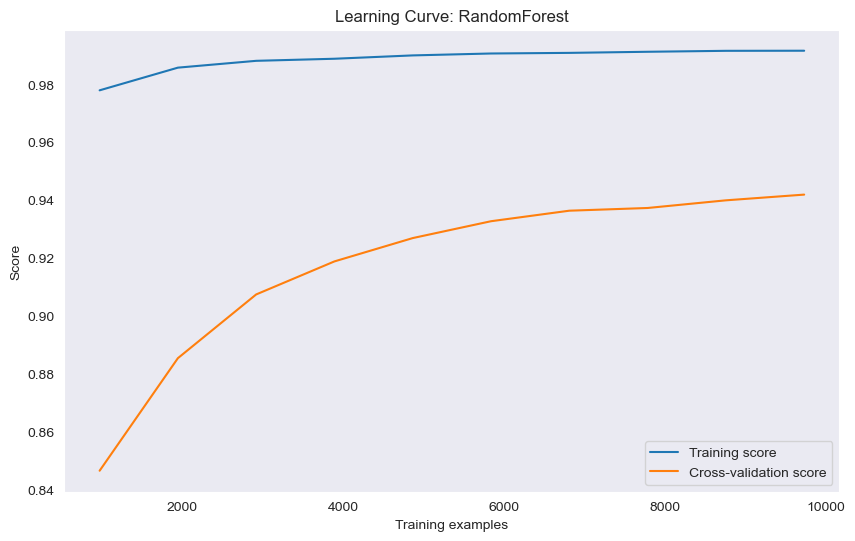

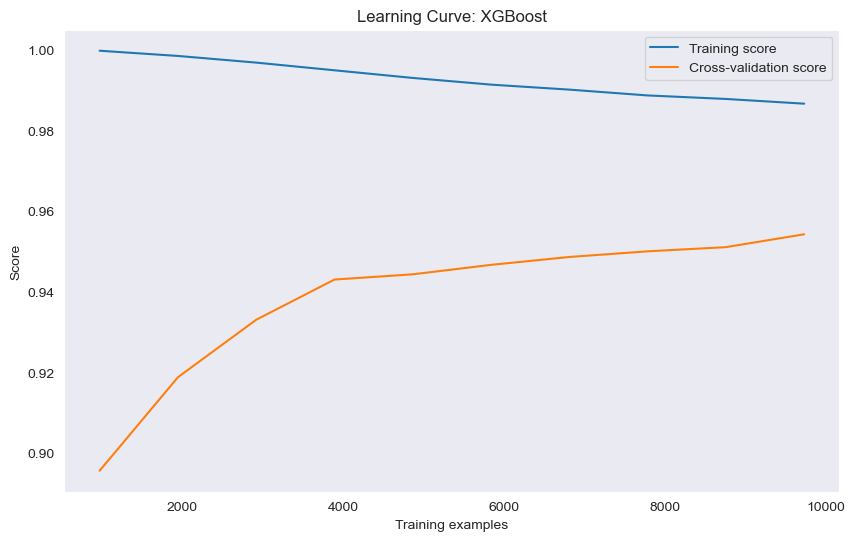

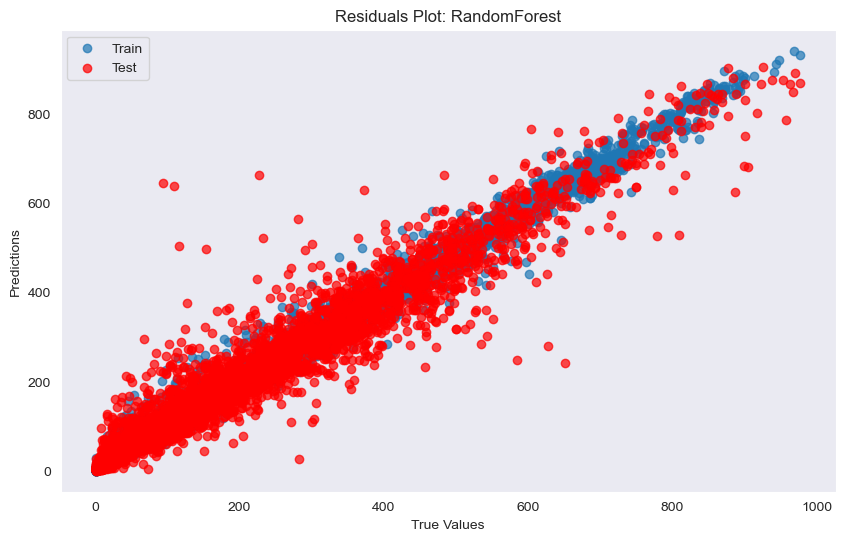

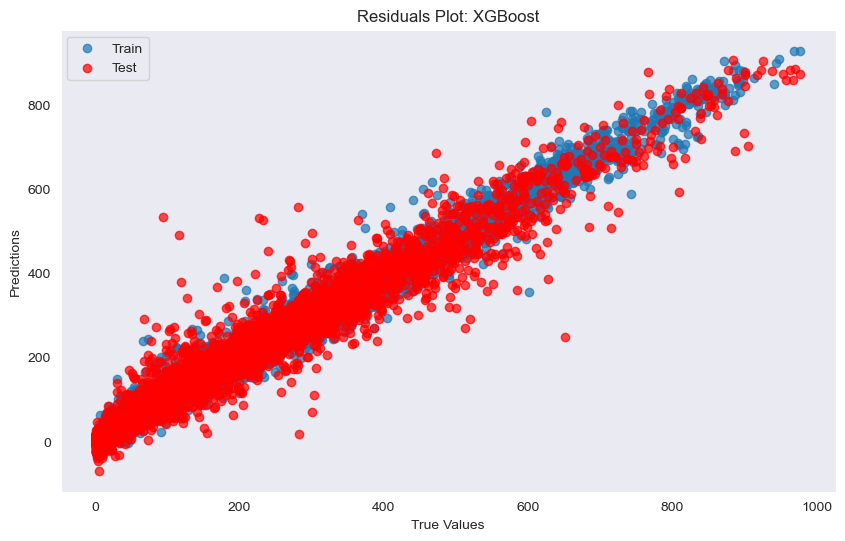

In [107]:
# Function to plot learning curves
def plot_learning_curve(model, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, cv=5, n_jobs=-1, scoring='r2', train_sizes=np.linspace(0.1, 1.0, 10))
    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, train_scores_mean, label='Training score')
    plt.plot(train_sizes, test_scores_mean, label='Cross-validation score')
    plt.title(f'Learning Curve: {title}')
    plt.xlabel('Training examples')
    plt.ylabel('Score')
    plt.legend()
    plt.grid()
    plt.show()

# Plot learning curves for the tuned models
for model_name, model in best_models.items():
    plot_learning_curve(model, X_train_processed_df, y_train.values.ravel(), model_name)

# Function to plot residuals
def plot_residuals(model, X_train, y_train, X_test, y_test, title):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    plt.figure(figsize=(10, 6))
    plt.scatter(y_train, y_train_pred, label='Train', alpha=0.7)
    plt.scatter(y_test, y_test_pred, label='Test', alpha=0.7, color='red')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title(f'Residuals Plot: {title}')
    plt.legend()
    plt.grid()
    plt.show()

# Plot residuals for the tuned models
for model_name, model in best_models.items():
    plot_residuals(model, X_train_processed_df, y_train.values.ravel(), X_test_processed_df, y_test.values.ravel(), model_name)


### Final Insights  results:

- __Residual Plots__: Residual plots display the differences between observed and predicted values (residuals). They help assess the quality of a regression model. Any discernible patterns suggest potential issues, such as non-linearity or model misspecification. In layman's terms, from the above plots for both the regressors, the model has performed pretty well as train and test data points are overlapping.


- __Learning Curves__: Learning curves plot the training and validation scores against the number of training examples. They provide insights into how a model learns over time. A small gap between training and validation scores suggests that the model generalizes well to unseen data. From the plots, it can be understood that as the number of samples increase, the gap between the curves shows a reducing trend which means that more data can improve the model even better.


- __Other things that could be done__: Implement other ensemble learning from the scikit learn by combining multiple models like stacking, bagging or apply neural networks like LSTMs which has a huge scope of improvement by tuning parameters like the number of sequential layers, hidden layers, dropout percentage, and optimizers. Use techniques like SHAP or LIME to interpret model predictions and identify areas for improvement.

## Part 2

### Scaling a Machine Learning Pipeline for Large Datasets:

#### Challenges of Scaling

When scaling a machine learning model to handle datasets that grow to several terabytes, several challenges arise, including increased computational load, data storage management, and model complexity. The key issues in this implementation include:

- __Data Volume__: The current traditional data processing techniques may become inefficient with larger datasets, leading to slow training times and potential memory issues.

- __Feature Engineering__: As the dataset grows, the complexity of feature engineering increases.

- __Storage limitations__: Storing and managing terabytes of data demands efficient storage solutions.

- __Model training and evaluation__: Training complex models on massive datasets can be computationally expensive and time-consuming.


#### Scalable Solution Architecture:

- __Distributed Data Storage__: 
    - Utilize platforms like Amazon S3, Google Cloud Storage, or Azure Blob Storage for cost-effective and scalable data storage.  
    - Create a centralized repository like Data Lakes for structured, semi-structured, and unstructured data. 
    - Divide the dataset into smaller, manageable chunks for distributed processing.
    
    
- __Distributed Data Processing__:
    - Employ frameworks like Apache Spark or Apache Flink for parallel and distributed data processing.
    - Use these frameworks to efficiently load, clean, and transform data in a distributed manner.
    - Extract relevant features from the data using distributed algorithms and libraries.
    
 
 - __Dask__: 
     - Dask enables efficient parallel computations on multi-core machines or distributed clusters.
     - It leverages familiar Python libraries like NumPy and Pandas, making the transition smooth.
     - Handles large datasets that don't fit into memory by breaking them into smaller chunks and processing them in parallel.
     - Supports various computational patterns (delayed execution, parallel loops, distributed arrays) for diverse workloads.
     
     
- __Scalable Model Training__:
    - Leverage frameworks like TensorFlow Distributed, PyTorch Distributed, or Apache Spark MLlib for distributed model training.
    - Distribute model training across multiple machines to accelerate computation.
    
    
- __Model Serving__: 
    - Deploy trained models on cloud platforms like AWS SageMaker, Google Cloud AI Platform, or Azure Machine Learning for scalable inference.
    - Use frameworks like TensorFlow Serving or TorchServe for efficient model deployment and serving.
    
    
#### Limitations and possible soultions of the proposed methods: 
The proposed architecture offers excellent scalability due to the distributed nature of data storage and processing. However, challenges may arise:

- Ensuring data consistency across distributed systems can be complex. Therefore we can employ distributed consensus algorithms (e.g., Raft, Paxos) for strong consistency guarantees or use eventual consistency for less stringent requirements.
- Communication overhead between distributed components can impact performance.Therefore, we can use techniques like data locality and caching.
- Cloud-based solutions and distributed frameworks can incur significant costs. Therefore, evaluate cloud provider pricing models, optimize resource utilization, and explore cost-saving options like spot instances. 


#### Hands-on Experience:

- __Cloud Platforms__: 
    - Proven experience with Microsoft Azure in data storage and model deployment within enterprise environments (Ladeplan, BASF).
    - Hands-on experience with AWS S3, Athena, Lambda, and Glue jobs and catalogs for data processing and management in a freelance project.
    
    
- __Big Data and Processing__:
    - Extensive proficiency in utilizing __PySpark__ for large-scale data processing and machine learning across multiple work experiences for many years.
    - In-depth knowledge of Docker containerization from both academic research (thesis) and professional experience (SICP).
    
 
 - __Cost and Resource Allocation__:
     - I have extensive experience developing a minimum viable product in the form of plugin at __SICP__ from scratch that addresses the problem of evaluating cloud provider pricing models, and optimizing resource utilization. 
     - I have different technologies like Python, Infrstructure as Code tool (IaC) __Terraform__ and a supported plugin called __Infracost__ to achieve this task.